# Dogs v Cats
A simple ConvNet inspired by Francois' [article](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)


In [4]:
%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [25]:
root_path = "data/dogscats-redux/"

path = root_path
#path = root_path + "sample/"

A few basic libraries that we'll need for the initial exercises:

In [6]:
from __future__ import division,print_function

import os, json, shutil, random, math
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [7]:
import utils; reload(utils)
from utils import plots

Using cuDNN version 5103 on context None
Mapped name None to device cuda: Tesla K80 (7E70:00:00.0)
Using Theano backend.


In [8]:
def predict_and_show(batches):
    imgs, labels = next(batches)
    preds, indexes, predicted_labels = vgg.predict(imgs)
    true_labels = [vgg.classes[idx] for idx in np.argmax(labels, axis=1)]
    plots(imgs, titles=['ok' if a == b else 'wrong' for (a,b) in zip(true_labels, predicted_labels)])

In [10]:
def plot_train_validation_curves(title, training_series, validation_series):
    num_epochs = len(training_series)
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, validation_series, label='validation')
    plt.plot(epochs, training_series, label='train')
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Define our model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator

In [26]:
model = Sequential()
model.add(Conv2D(32, 3, 3, input_shape=(3, 224, 224), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# at this point the model's output is a 3D feature map (height, width, features)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

## get training and validation data

In [36]:
batch_size = 64
train_gen = ImageDataGenerator(rescale=1./255., horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1./255.)
def get_batches(image_dir_path, generator, batch_size):
    return generator.flow_from_directory(image_dir_path, batch_size=batch_size,
                                         class_mode='binary', # because loss=binary_crossentropy
                                         target_size=(224,224))
train_generator = get_batches(path+'train', train_gen, batch_size=batch_size)
validation_generator = get_batches(path+'validation', test_gen, batch_size=batch_size)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## train the model

In [28]:
hist = model.fit_generator(train_generator, 
                    nb_epoch=5,
                    samples_per_epoch=train_generator.nb_sample,
                    validation_data=validation_generator, 
                    nb_val_samples=validation_generator.nb_sample,
                    verbose=1, 
                    callbacks=None)
model.save_weights(path+'kl_first_try.h5')

Epoch 1/5
20000/20000 [==============================] - 1080s - loss: 0.6338 - acc: 0.6436 - val_loss: 0.5490 - val_acc: 0.7186
Epoch 2/5
20000/20000 [==============================] - 232s - loss: 0.5101 - acc: 0.7536 - val_loss: 0.4663 - val_acc: 0.7726
Epoch 3/5
20000/20000 [==============================] - 230s - loss: 0.4598 - acc: 0.7863 - val_loss: 0.4673 - val_acc: 0.7828
Epoch 4/5
20000/20000 [==============================] - 230s - loss: 0.4299 - acc: 0.8047 - val_loss: 0.4541 - val_acc: 0.7896
Epoch 5/5
20000/20000 [==============================] - 231s - loss: 0.4089 - acc: 0.8173 - val_loss: 0.3952 - val_acc: 0.8156


## evaluate performance

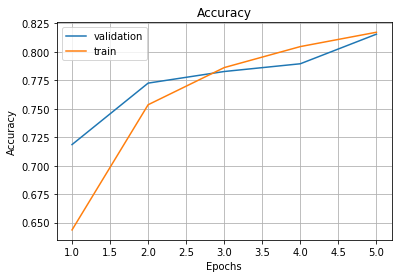

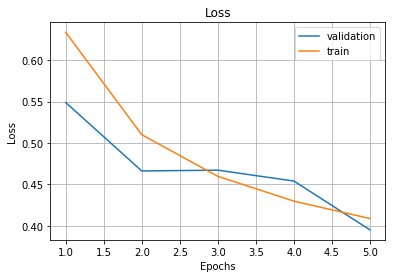

In [29]:
plot_train_validation_curves('Accuracy', hist.history['acc'], hist.history['val_acc'])
plot_train_validation_curves('Loss', hist.history['loss'], hist.history['val_loss'])

## kick the tires

In [45]:
demo_batches = get_batches(path+'train', ImageDataGenerator(), batch_size=6)

Found 20000 images belonging to 2 classes.


[ 0.  1.  1.  0.  0.  0.]


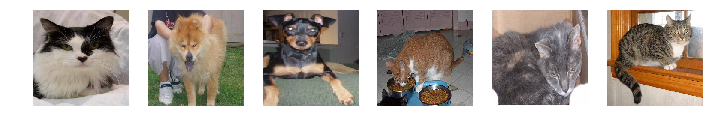

In [49]:
imgs, labels = next(demo_batches)
print(labels)
plots(imgs)

# Kaggle Submission

In [50]:
from keras.preprocessing.image import ImageDataGenerator

def get_test_batches(path, batch_size):
    gen = ImageDataGenerator()
    return gen.flow_from_directory(path, target_size=(224,224), class_mode=None, shuffle=False, batch_size=batch_size)

In [54]:
test_batches = get_test_batches(path + 'test', batch_size=32)

Found 12500 images belonging to 1 classes.


In [55]:
dog_predictions = model.predict_generator(test_batches, test_batches.nb_sample)
dog_predictions[:5]

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.]], dtype=float32)

Extract the id of each image in the test batch because Keras ImageDataGenerator will enumerate them in lexical order

In [56]:
ids = [int(x.split("/")[1].split(".")[0]) for x in test_batches.filenames]

In [61]:
dog_predictions[3]

array([ 0.], dtype=float32)

fill out the submission table

In [ ]:
with open(root_path + 'keith_submission_simple_from_scratch.csv', 'w') as f:
    f.write('id,label\n')
    for i in range(len(ids)):
        f.write('{},{}\n'.format(ids[i], dog_predictions[i]))